## sampler.py

In [1]:
import numpy as np

class Sampler:
    def __init__(self):
        self.psi=None
        self.x=0
        self.accept=0
        self.moves=0

    def SetPsi(self,Psi):
        self.psi=Psi

    #Markov-Chain transitions
    #the particle is displaced by a uniform random quantity
    #in 0.5[-step_size,step_size]
    def Propose(self,step_size):
        return self.x+(np.random.uniform()-0.5)*step_size

    #Metropolis-Hastings acceptance test
    def Step(self,step_size):
        xprime=self.Propose(step_size)
        #we compute (Psi(xprime)/Psi(x))^2
        #in order to avoid overflow/underflow, we use the logarithm of the wave-function
        if(np.exp(2.*(self.psi.LogVal(xprime)-self.psi.LogVal(self.x))) > np.random.uniform()):
            self.x=xprime
            self.accept+=1
        self.moves+=1


    def Acceptance(self):
        return self.accept/float(self.moves)

    #Local energy (see script)
    def LocalEnergy(self,pot):
        return -0.5*self.psi.Nabla2OPsi(self.x)+pot(self.x)

## state.py

#### Particle in a Box:

##### Trial Wavefunction (ansatz):

$\psi(\alpha , x) = \begin{cases}
      (L^2 - x^2)(L^2 - \alpha x^2) & -L \leq x \leq L\\
      0 & \text{otherwise}\\
    \end{cases}$
    
where $\alpha$ is our variational parameter, $2L$ = width of our box  

source: http://demonstrations.wolfram.com/VariationalPrincipleForQuantumParticleInABox/

$\alpha_{min} = 0.221, 7.32$ 

$E(0.221) =  1.000$


##### Alternative Ansatz:

sources: https://www.youtube.com/watch?v=-1zd4k29Jgk, and  http://sydney.edu.au/science/chemistry/~mjtj/CHEM3117/Resources/var_pr.pdf

$\psi(x) = N (x(L-x))^\alpha$

where N = normalization constant, $\alpha$ = variational parameter

In [2]:
class State:
    def __init__(self,p1):
        self.p1=p1  # alpha
        
#     Particle in box ansatz wavefn
    def __call__(self,x):
        L = 50  # Well width = 2*L
        if (x >= -L) and (x <= L):
            return (L**2 - x**2) * (L**2 - self.p1*x**2)
        else:
            return 0  # At potential barrier, returns zero wavefn.

    #Compute the logarithm of the wave-function for particle in a box 
    def LogVal(self,x):
        L = 50  # 2*L = Well width
        if (x >= -L) and (x <= L):
            return np.log((L**2 - x**2) * (L**2 - self.p1*x**2))
        else:
            return -1000000000000000 # log(zero) --> negative infinity  

    #Set the variational parameter
    def SetParam(self,p1):
        self.p1=p1

    #Get the variational parameter
    def GetParam(self):
        return self.p1

    #Computes the Derivative of LogPsi with
    #respect to the variational parameter
    def DerLog(self,x):
        L = 50  # 2*L = Well width
        if (x >= -L) and (x <= L):
            return x ** 2 / (self.p1 ** 2 * x - L ** 2)
        else:
            return 0

    #Computes (Nabla^2*Psi)/Psi
    #Needed in the local energy
    def Nabla2OPsi(self,x):
#         return 2.*self.p1+(2.*self.p1*x)**2.
        L = 50
        if (x >= -L) and (x <= L):
            return (12 * self.p1 * x ** 2 - 2 * (self.p1 + 1) * L ** 2)/ ((L**2 - x**2) * (L**2 - self.p1*x**2) )
        else:
            return 0

## optimize_harmonic.py

alpha  =  0.999999999999
energy =  0.000799905199731  variance =  7.7843929381e-08
gradient variance =  1.59435544632e-11 

alpha  =  0.999999999971
energy =  0.000799202008767  variance =  4.77379583671e-07
gradient variance =  5.86840632319e-10 

alpha  =  0.999999999964
energy =  0.000799458080716  variance =  2.40112418093e-07
gradient variance =  2.19097142954e-10 

alpha  =  0.999999999962
energy =  0.000799746232393  variance =  1.29803036726e-07
gradient variance =  6.09756288716e-11 

alpha  =  0.999999999911
energy =  0.000798965622783  variance =  6.39279554751e-07
gradient variance =  1.1585720514e-09 

alpha  =  0.999999999426
energy =  0.000795919104249  variance =  1.99907659343e-06
gradient variance =  1.12245590022e-08 

alpha  =  0.999999999378
energy =  0.000793190090908  variance =  6.32348905222e-07
gradient variance =  5.20689479239e-09 

alpha  =  0.999999999314
energy =  0.000793967908643  variance =  7.33977870745e-07
gradient variance =  6.24120166028e-09 

al

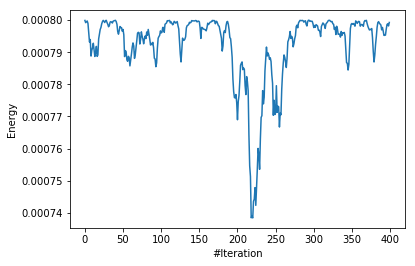

In [3]:
# from sampler import *
# from state import *
import matplotlib.pyplot as plt

# Potential energy term
def box(x):
    L = 50
    if (x >= -L) and (x <= L):
        potential_energy = 0
    else:
        potential_energy = -10000000000000000
    return potential_energy

psi=State(1)
vmc=Sampler()
nsteps=1000
stepsopt=400
learning_rate=0.1

enopt=[]

for i in range(stepsopt):
    vmc.SetPsi(psi)

    elocs=np.zeros(nsteps)
    psider=np.zeros(nsteps)

    for n in range(nsteps):
        vmc.Step(0.1)

        elocs[n]=(vmc.LocalEnergy(box))
        psider[n]=(psi.DerLog(vmc.x))

    energy=np.mean(elocs)
    elocders=(elocs-energy)*psider
    elocder=np.mean(elocders)
    psi.SetParam(psi.GetParam()-learning_rate*elocder)

    enopt.append(energy)
    
    print("alpha  = ",psi.GetParam())
    print("energy = ",energy," variance = ",np.std(elocs))
    print("gradient variance = ",np.std(elocders),'\n')

plt.plot(enopt)
# plt.axhline(0.5,color='black')
plt.ylabel('Energy')
plt.xlabel('#Iteration')
plt.show()

https://galeascience.wordpress.com/2016/05/25/variational-monte-carlo/

In [4]:
print((vmc.LocalEnergy(box)))

0.000799665429049


# Original Code Harmonic

In [5]:
import numpy as np

class Sampler:
    def __init__(self):
        self.psi=None
        self.x=0
        self.accept=0
        self.moves=0

    def SetPsi(self,Psi):
        self.psi=Psi

    #Markov-Chain transitions
    #the particle is displaced by a uniform random quantity
    #in 0.5[-step_size,step_size]
    def Propose(self,step_size):
        return self.x+(np.random.uniform()-0.5)*step_size

    #Metropolis-Hastings acceptance test
    def Step(self,step_size):
        xprime=self.Propose(step_size)
        #we compute (Psi(xprime)/Psi(x))^2
        #in order to avoid overflow/underflow, we use the logarithm of the wave-function
        if(np.exp(2.*(self.psi.LogVal(xprime)-self.psi.LogVal(self.x))) > np.random.uniform()):
            self.x=xprime
            self.accept+=1
        self.moves+=1


    def Acceptance(self):
        return self.accept/float(self.moves)

    #Local energy (see script)
    def LocalEnergy(self,pot):
        return -0.5*self.psi.Nabla2OPsi(self.x)+pot(self.x)


In [6]:
class State:
    def __init__(self,p1):
        self.p1=p1

    def __call__(self,x):
        return np.exp(self.p1*x**2.)

    #Compute the logarithm of the wave-function
    def LogVal(self,x):
        return self.p1*x**2.

    #Set the variational parameter
    def SetParam(self,p1):
        self.p1=p1

    #Get the variational parameter
    def GetParam(self):
        return self.p1

    #Computes the Derivative of LogPsi with
    #srespect to the variational parameter
    def DerLog(self,x):
        return x**2.

    #Computes (Nabla^2*Psi)/Psi
    #Needed in the local energy
    def Nabla2OPsi(self,x):
        return 2.*self.p1+(2.*self.p1*x)**2.


alpha  =  -99.8738434181
energy =  51.1462553153  variance =  71.0361676844
gradient variance =  0.889684259271 

alpha  =  -99.8112391778
energy =  61.1182739914  variance =  49.9779215662
gradient variance =  0.384561694581 

alpha  =  -99.6942632654
energy =  55.1216860678  variance =  68.2735074176
gradient variance =  1.01609907556 

alpha  =  -99.6041684425
energy =  53.1810391807  variance =  59.8473079633
gradient variance =  0.611856283914 

alpha  =  -99.4502075745
energy =  44.0111159291  variance =  78.1640786759
gradient variance =  1.28506994027 

alpha  =  -99.3800353402
energy =  60.1477115452  variance =  52.6881382532
gradient variance =  0.565676301692 

alpha  =  -99.3030945538
energy =  59.4842611121  variance =  55.131772605
gradient variance =  0.625587982848 

alpha  =  -99.1580884525
energy =  36.6343147062  variance =  75.6276161114
gradient variance =  0.928418634008 

alpha  =  -99.0472288916
energy =  50.9295372591  variance =  66.0296807135
gradient varian

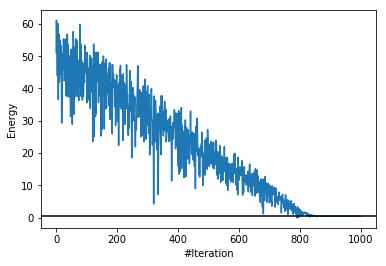

In [7]:
import matplotlib.pyplot as plt

def harmonic(x):
    return 0.5*x**2.


psi=State(-100)
vmc=Sampler()
nsteps=1000
stepsopt=1000
learning_rate=0.5

enopt=[]

for i in range(stepsopt):
    vmc.SetPsi(psi)

    elocs=np.zeros(nsteps)
    psider=np.zeros(nsteps)

    for n in range(nsteps):
        vmc.Step(0.1)

        elocs[n]=(vmc.LocalEnergy(harmonic))
        psider[n]=(psi.DerLog(vmc.x))


    energy=np.mean(elocs)
    elocders=(elocs-energy)*psider
    elocder=np.mean(elocders)
    psi.SetParam(psi.GetParam()-learning_rate*elocder)



    enopt.append(energy)
    print("alpha  = ",psi.GetParam())
    print("energy = ",energy," variance = ",np.std(elocs))
    print("gradient variance = ",np.std(elocders),'\n')

plt.plot(enopt)
plt.axhline(0.5,color='black')
plt.ylabel('Energy')
plt.xlabel('#Iteration')
plt.show()
